<a href="https://colab.research.google.com/github/yaroslav711/nst/blob/master/comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
#Импорты
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from io import BytesIO
from PIL import Image
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras


In [46]:
#Загрузка изображений
upl = files.upload()
img = Image.open(BytesIO(upl['img.jpg']))
img_style = Image.open(BytesIO(upl['img_style.jpg']))

Saving img.jpg to img (4).jpg
Saving img_style.jpg to img_style (4).jpg


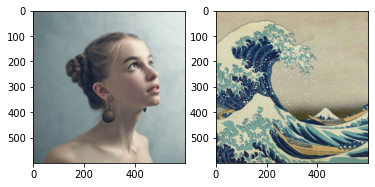

In [47]:
plt.subplot(1, 2, 1)
plt.imshow( img )
plt.subplot(1, 2, 2)
plt.imshow( img_style )
plt.show()

In [48]:
x_img = keras.applications.vgg19.preprocess_input( np.expand_dims(img, axis=0) )
x_style = keras.applications.vgg19.preprocess_input(np.expand_dims(img_style, axis=0))

In [49]:
#Функция перевода изображения из BGR в RGB
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  #Параметры перевода из BGR в RGB
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [50]:
#Используем предобученную нейронную сеть VGG19 с собственными весами. Сделаем эти веса необучаемыми
vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

In [51]:
#Создадим коллекции с названиями слоев, необходимых для дальнейшего выделения их из сети VGG19. Данные слои помогут в оценке лосса.
content_layers = ['block5_conv2'] 


style_layers = ['block1_conv1',
            'block2_conv1',
            'block3_conv1', 
            'block4_conv1', 
            'block5_conv1']

#Количество необходимых слоев для стиля\контента
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [52]:
#Создадим список тензоров для стиля, контента и общий список необходимых тензоров
style_outputs = [vgg.get_layer(name).output for name in style_layers]
content_outputs = [vgg.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs
model = keras.models.Model(vgg.input, model_outputs)

In [53]:
def get_feature_representations(model):
  # Вычисление стиля и контента
  style_outputs = model(x_style)
  content_outputs = model(x_img)
  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  return tf.reduce_mean(tf.square(gram_style - gram_target))

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Подсчет потерей по стилю со всех слоев
  # Подсчет общей потери с одинаковыми весами слоев
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Подсчет потерей по контенту со всех слоев
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Подсчет общих потерь
  loss = style_score + content_score 
  return loss, style_score, content_score

In [54]:
#Параметры полученные путем проб и ошибок))
#Кол-во итераций влияет на степень стилизации (чем больше - тем изображение больше соответсвует стилю)
num_iterations=7500
content_weight=1e3
style_weight=1e-2

style_features, content_features = get_feature_representations(model)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

init_image = np.copy(x_img)
init_image = tf.Variable(init_image, dtype=tf.float32)

#Создание оптимизатора Адам с гиперпараметрами полученными путем тех же проб и ошибок
opt = tf.compat.v1.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1)
iter_count = 1
best_loss, best_img = float('inf'), None
loss_weights = (style_weight, content_weight)

cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
}

norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means
imgs = []

for i in range(num_iterations):
    with tf.GradientTape() as tape: 
       all_loss = compute_loss(**cfg)
    loss, style_score, content_score = all_loss
    grads = tape.gradient(loss, init_image)

    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    
    if loss < best_loss:
      # Обновим потери и лучшее изображение
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

      # Вернем изображение к привычной цветовой гамме RGB
      plot_img = deprocess_img(init_image.numpy())
      imgs.append(plot_img)

tf.Tensor(176794.47, shape=(), dtype=float32)


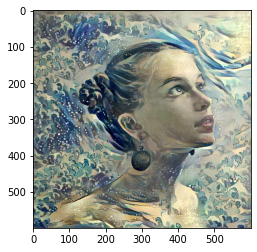

In [55]:
#Вывод изображения
plt.imshow(best_img)
print(best_loss)

In [56]:
#Сохранение изображения
image = Image.fromarray(best_img.astype('uint8'), 'RGB')
image.save("result.jpg")
files.download("result.jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>